In [323]:
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')  # oder 'Qt5Agg', je nachdem, was installiert ist
%matplotlib inline
import matplotlib.pyplot as plt

tracking_data = pd.read_pickle('tracking_data.pkl')
tracking_data_full = pd.read_pickle('tracking_data_full.pkl')
tracking = pd.read_pickle('tracking.pkl')

In [324]:
ballbesitz = tracking[tracking['POSSESSION_TRACKABLE_OBJECT'].notna()]

spieler_team_df = ballbesitz[['POSSESSION_TRACKABLE_OBJECT', 'POSSESSION_GROUP']].drop_duplicates()

spieler_team_map = spieler_team_df.groupby('POSSESSION_TRACKABLE_OBJECT')['POSSESSION_GROUP'].agg(lambda x: x.mode())
away_team_ids = spieler_team_map[spieler_team_map == "away team"].index.tolist()
home_team_ids = spieler_team_map[spieler_team_map == "home team"].index.tolist()

In [325]:
tracking_ball = tracking_data_full[tracking_data_full['TRACK_ID'] == 55].copy()
tracking_ball

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
24,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,00:00:00.1,0 days 00:00:00.100000
47,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,00:00:00.2,0 days 00:00:00.200000
76,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,00:00:00.3,0 days 00:00:00.300000
93,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,00:00:00.4,0 days 00:00:00.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
1108534,105690,57448,55,55,False,-31.62,-5.59,2.0,home team,<NA>,01:34:35.8,0 days 01:34:35.800000
1108559,105690,57449,55,55,False,-30.79,-4.73,2.0,home team,<NA>,01:34:35.9,0 days 01:34:35.900000
1108580,105690,57450,55,55,False,-29.94,-3.75,2.0,home team,<NA>,01:34:36,0 days 01:34:36
1108604,105690,57451,55,55,False,-29.56,-2.92,2.0,home team,<NA>,01:34:36.1,0 days 01:34:36.100000


Der Ball fliegt gerade wenn die Geschwindikeit hoch ist und die Richtung des Balls sich nicht stark ändert.

In [326]:
tracking_ball['ball_in_game'] = tracking_ball['TIME_DELTA'].diff() <= "00:00:00.1"

In [327]:
tracking_ball['dX'] = tracking_ball['X'].diff()
tracking_ball['dY'] = tracking_ball['Y'].diff()

In [328]:
tracking_ball['speed'] = np.sqrt(tracking_ball['dX']**2 + tracking_ball['dY']**2)

In [329]:
def circdiff(a, b, period=360.0):
    return (a - b + period/2) % period - period/2

tracking_ball['angle'] = np.degrees(np.arctan2(tracking_ball['dY'], tracking_ball['dX']))

# 1‑Frame-Differenz
tracking_ball['angle_change'] = circdiff(
    tracking_ball['angle'],
    tracking_ball['angle'].shift(-1)
)

# 2‑Frame-Differenz
tracking_ball['angle_diff_2frames'] = circdiff(
    tracking_ball['angle'].shift(-2),
    tracking_ball['angle']
)


In [330]:
tracking_ball['ball_in_motion'] = (tracking_ball['speed'] >= 0.5) & (tracking_ball['angle_change'].abs() <=10) & (tracking_ball['ball_in_game']) & (tracking_ball['angle_diff_2frames'].abs() <=15)

Bei einem Pass muss der Ball mindestens 5 Frames hintereinander in Bewegung sein. Filtere also nur diejenigen Frames bei denen ball_in_motion jeweils 5mal hintereinander True ist

In [331]:
tracking_ball['motion_number'] = (tracking_ball['ball_in_motion'] != tracking_ball['ball_in_motion'].shift()).cumsum()

group_sizes = tracking_ball.groupby('motion_number')['ball_in_motion'].transform('sum')

tracking_ball['pass'] = (tracking_ball['ball_in_motion']) & (group_sizes >= 8)

Problematisch bisher: Kurze Pässe und lange Dribblings mit Ball geradeaus.

In [332]:
tracking_ball

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,ball_in_game,dX,dY,speed,angle,angle_change,angle_diff_2frames,ball_in_motion,motion_number,pass
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,1,False
24,105690,61,55,55,True,0.23,-1.64,1.0,NaN,<NA>,...,True,-0.15,-0.61,0.628172,-103.815025,39.931137,-58.001322,False,1,False
47,105690,62,55,55,True,-1.12,-2.63,1.0,NaN,<NA>,...,True,-1.35,-0.99,1.674097,-143.746162,18.070185,14.572504,False,1,False
76,105690,63,55,55,False,-2.49,-3.08,1.0,NaN,<NA>,...,True,-1.37,-0.45,1.442012,-161.816347,-32.642689,33.659120,False,1,False
93,105690,64,55,55,False,-2.71,-3.35,1.0,NaN,<NA>,...,True,-0.22,-0.27,0.348281,-129.173658,-1.016431,6.512745,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108534,105690,57448,55,55,False,-31.62,-5.59,2.0,home team,<NA>,...,True,0.68,0.75,1.012373,47.802452,1.785473,1.260914,True,3918,False
1108559,105690,57449,55,55,False,-30.79,-4.73,2.0,home team,<NA>,...,True,0.83,0.86,1.195199,46.016978,-3.046388,19.383231,False,3919,False
1108580,105690,57450,55,55,False,-29.94,-3.75,2.0,home team,<NA>,...,True,0.85,0.98,1.297266,49.063366,-16.336843,-11.036135,False,3919,False
1108604,105690,57451,55,55,False,-29.56,-2.92,2.0,home team,<NA>,...,True,0.38,0.83,0.912853,65.400209,27.372979,NaN,False,3919,False


In [333]:
tracking_ball.to_pickle('tracking_ball.pkl')

In [334]:
passes = tracking_ball[tracking_ball['pass'] == True].copy()

Nummeriere Pässe durch

In [335]:
unique_motions = passes['motion_number'].dropna().unique()
motion_map = {old: new for new, old in enumerate(sorted(unique_motions), start=1)}

passes['motion_number'] = passes['motion_number'].map(motion_map)

In [336]:
passes

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,...,ball_in_game,dX,dY,speed,angle,angle_change,angle_diff_2frames,ball_in_motion,motion_number,pass
806,105690,95,55,55,True,-0.59,1.84,1.0,away team,28566,...,True,-0.46,0.54,0.709366,130.426079,-8.387996,13.045066,True,1,True
829,105690,96,55,55,True,-1.23,2.40,1.0,away team,28566,...,True,-0.64,0.56,0.850412,138.814075,-4.657070,8.600218,True,1,True
852,105690,97,55,55,True,-2.04,3.00,1.0,away team,<NA>,...,True,-0.81,0.60,1.008018,143.471145,-3.943148,7.197016,True,1,True
875,105690,98,55,55,True,-3.01,3.62,1.0,away team,<NA>,...,True,-0.97,0.62,1.151217,147.414293,-3.253868,3.201550,True,1,True
898,105690,99,55,55,True,-4.06,4.21,1.0,away team,<NA>,...,True,-1.05,0.59,1.204409,150.668160,0.052318,-0.613844,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107300,105690,57394,55,55,False,-38.39,-12.98,2.0,away team,<NA>,...,True,-0.69,0.76,1.026499,132.236143,-1.945402,1.410665,True,840,True
1107321,105690,57395,55,55,False,-39.08,-12.27,2.0,away team,<NA>,...,True,-0.69,0.71,0.990051,134.181545,0.534736,-1.628593,True,840,True
1107339,105690,57396,55,55,False,-39.70,-11.62,2.0,away team,<NA>,...,True,-0.62,0.65,0.898276,133.646808,1.093857,-1.538078,True,840,True
1107362,105690,57397,55,55,False,-40.26,-11.01,2.0,away team,<NA>,...,True,-0.56,0.61,0.828070,132.552951,0.444221,-3.408965,True,840,True


In [337]:
len(passes['motion_number'].unique())

840

In [338]:
# Funktion zur Extraktion eines Passes als eine Zeile
def extract_pass_info(group):
    start = group.iloc[0]
    end = group.iloc[-1]
    
    return pd.Series({
        'motion_number': start['motion_number'],
        'start_X': start['X'],
        'start_Y': start['Y'],
        'end_X': end['X'],
        'end_Y': end['Y'],
        'PERIOD': start['PERIOD'],
        'POSSESSION_GROUP_start': start['POSSESSION_GROUP'],
        'POSSESSION_GROUP_end': end['POSSESSION_GROUP'],
        'FRAME_START': start['FRAME'],
        'FRAME_END': end['FRAME'],
        'POSSESSION_TRACKABLE_OBJECT': start['POSSESSION_TRACKABLE_OBJECT'],
        'Angekommen': start['POSSESSION_GROUP'] == end['POSSESSION_GROUP']
    })

# Nach motion_number gruppieren und pro Pass zusammenfassen
passes_summary = passes.groupby('motion_number').apply(extract_pass_info).reset_index(drop=True)

In [339]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen
0,1,-0.59,1.84,-13.07,10.93,1.0,away team,away team,95,112,28566,True
1,2,-13.24,13.54,-3.90,28.36,1.0,away team,away team,117,131,24372,True
2,3,1.99,31.32,-8.89,29.12,1.0,home team,home team,171,188,<NA>,True
3,4,-6.60,24.64,8.48,26.09,1.0,away team,away team,233,241,<NA>,True
4,5,8.95,31.28,18.22,23.76,1.0,away team,home team,259,268,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True
836,837,6.68,-20.79,-11.24,-32.42,2.0,away team,away team,57136,57162,<NA>,True
837,838,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True
838,839,-32.55,0.98,-21.53,-21.72,2.0,away team,away team,57355,57364,<NA>,True


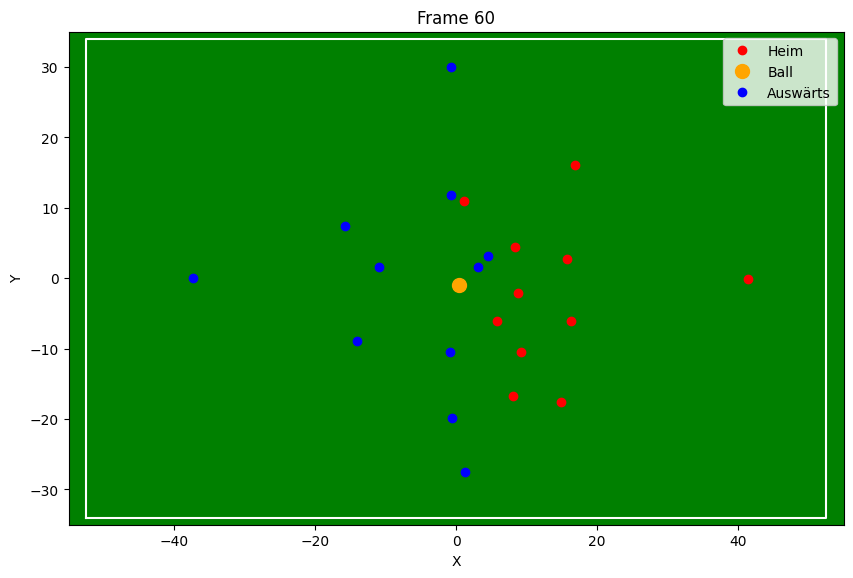

In [340]:
import matplotlib.pyplot as plt

def plot_spieler(tracking_df, frame, pass_number=None, team0_ids=away_team_ids, team1_ids=home_team_ids, ball_id=55, ax=None, plot_pass_area = False):
    df = tracking_df[tracking_df['FRAME'] == frame]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.clear()  # WICHTIG für Animation!
    ax.set_facecolor('green')
    ax.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")

    ax.set_xlim(-55, 55)
    ax.set_ylim(-35, 35)
    ax.set_aspect('equal')

    ball_plotted = team0_plotted = team1_plotted = False

    for _, row in df.iterrows():
        if row['TRACK_ID'] == ball_id:
            ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10, label='Ball' if not ball_plotted else "")
            ball_plotted = True
        elif team0_ids and row['TRACK_ID'] in team0_ids:
            ax.plot(row['X'], row['Y'], 'o', color='blue', label='Auswärts' if not team0_plotted else "")
            team0_plotted = True
        elif team1_ids and row['TRACK_ID'] in team1_ids:
            ax.plot(row['X'], row['Y'], 'o', color='red', label='Heim' if not team1_plotted else "")
            team1_plotted = True
        else:
            ax.plot(row['X'], row['Y'], 'o', color='gray')

    if pass_number is not None:
        pass_to_plot = passes_summary[passes_summary['motion_number'] == pass_number]
        if not pass_to_plot.empty:
            dx = pass_to_plot['end_X'].values[0] - pass_to_plot['start_X'].values[0]
            dy = pass_to_plot['end_Y'].values[0] - pass_to_plot['start_Y'].values[0]
            ax.quiver(
                pass_to_plot['start_X'], pass_to_plot['start_Y'],
                dx, dy,
                angles='xy',
                scale_units='xy',
                scale=1,
                color='blue',
                width=0.003,
                headwidth=3,
                headlength=5)
        if plot_pass_area:
            x = [pass_to_plot['start_X'], pass_to_plot['start_X'], pass_to_plot['end_X'], pass_to_plot['end_X']]
            if pass_to_plot['start_Y'].values[0] < pass_to_plot['end_Y'].values[0]:
                y = [pass_to_plot['start_Y']-4, pass_to_plot['end_Y']+4, pass_to_plot['end_Y']+4, pass_to_plot['start_Y']-4]
            else:
                y = [pass_to_plot['start_Y']+4, pass_to_plot['end_Y']-4, pass_to_plot['end_Y']-4, pass_to_plot['start_Y']+4]
            ax.fill(x, y, color='yellow', alpha=0.3, hatch='//')

    ax.set_title(f"Frame {frame}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(loc='upper right')

plot_spieler(tracking_data, 60)

Als Nächtes möchte ich den Passgeber und Passempfänger identifizieren. Leider hat die Spalte 'POSSESSION_TRACKABLE_OBJECT' fehlende Werte. Daher nehme ich den nächsten Spieler zum Ball. Falls eine Ballbesitzmannschaft bekannt ist, nehme ich den nächsten Spieler zum Ball aus dieser Mannschaft.

In [341]:
def get_closest_player(frame, possession_group ,ball_id=55):

    #if POSSESSION_GROUP is known we search the clsoest player of this team

    frame_data = tracking_data[tracking_data['FRAME'] == frame]
    ball_pos = frame_data[frame_data['TRACK_ID'] == ball_id][['X', 'Y']]

    ball_x, ball_y = ball_pos.iloc[0]['X'], ball_pos.iloc[0]['Y']

    if possession_group == 'home team':
        players = frame_data[(frame_data['TRACK_ID'] != ball_id) & (frame_data['TRACK_ID'].isin(home_team_ids))][['TRACK_ID', 'X', 'Y']].copy()
    elif possession_group == "away team":
        players = frame_data[(frame_data['TRACK_ID'] != ball_id) & (frame_data['TRACK_ID'].isin(away_team_ids))][['TRACK_ID', 'X', 'Y']].copy()
    else:
        players = frame_data[(frame_data['TRACK_ID'] != ball_id)][['TRACK_ID', 'X', 'Y']].copy()


    players['distance_to_ball'] = ((players['X'] - ball_x)**2 + (players['Y'] - ball_y)**2)**0.5

    closest_player_id = players.loc[players['distance_to_ball'].idxmin()] ['TRACK_ID']

    return closest_player_id

get_closest_player(96, None)

28566.0

In [342]:
passes_summary['Passgeber'] = passes_summary.apply(
    lambda row: get_closest_player(row['FRAME_START'], row['POSSESSION_GROUP_start']),
    axis=1
)
passes_summary['Passempfänger'] = passes_summary.apply(
    lambda row: get_closest_player(row['FRAME_END'], row['POSSESSION_GROUP_end']),
    axis=1
)

Visualisiere Pässe von einem Spieler

In [343]:
motion_numbers = passes_summary[(passes_summary['Passgeber'] == 28555) & (passes_summary['PERIOD'] == 1)]['motion_number']

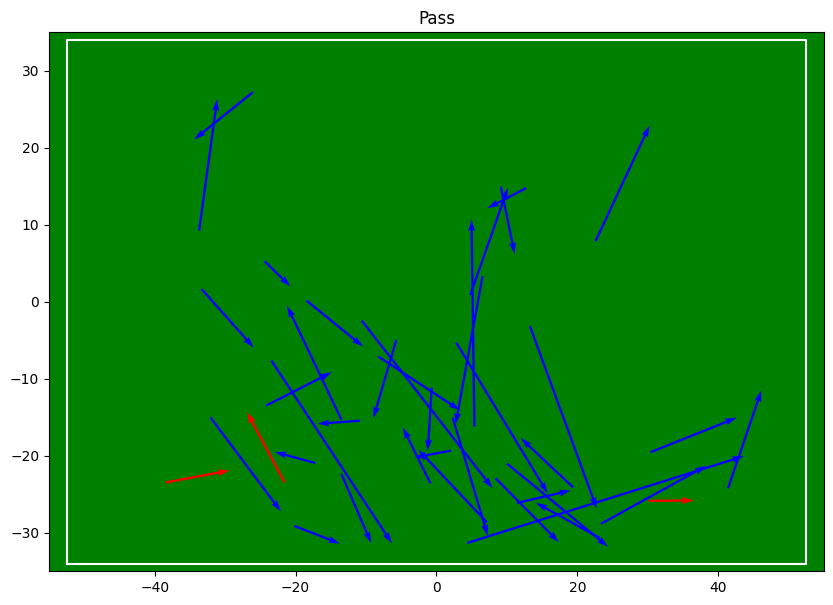

In [344]:
def visualize_passes(passes_summary, motion_numbers, show_player = False):
    pass_sequence = passes_summary[passes_summary['motion_number'].isin(motion_numbers)]
    
    plt.figure(figsize=(10, 7))
    plt.title("Pass")

    plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")
    plt.gca().set_facecolor("green")
    plt.xlim(-55, 55)
    plt.ylim(-35, 35)

    for _, row in pass_sequence.iterrows():
        color = 'blue' if row['Angekommen'] else 'red'
        dx = row['end_X'] - row['start_X']
        dy = row['end_Y'] - row['start_Y']

        plt.quiver(
            row['start_X'], row['start_Y'],  # Startpunkt
            dx, dy,                          # Richtungsvektor
            angles='xy',
            scale_units='xy',
            scale=1,
            color=color,
            width=0.003,
            headwidth=3,
            headlength=5
        )        

    plt.show()

visualize_passes(passes_summary, motion_numbers)


In [345]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger
0,1,-0.59,1.84,-13.07,10.93,1.0,away team,away team,95,112,28566,True,28566.0,24372.0
1,2,-13.24,13.54,-3.90,28.36,1.0,away team,away team,117,131,24372,True,24372.0,39023.0
2,3,1.99,31.32,-8.89,29.12,1.0,home team,home team,171,188,<NA>,True,16427.0,16471.0
3,4,-6.60,24.64,8.48,26.09,1.0,away team,away team,233,241,<NA>,True,24372.0,28566.0
4,5,8.95,31.28,18.22,23.76,1.0,away team,home team,259,268,<NA>,False,39023.0,39015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True,39023.0,39023.0
836,837,6.68,-20.79,-11.24,-32.42,2.0,away team,away team,57136,57162,<NA>,True,39023.0,39023.0
837,838,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True,14926.0,29957.0
838,839,-32.55,0.98,-21.53,-21.72,2.0,away team,away team,57355,57364,<NA>,True,29957.0,39023.0


## Überspielte Verteidiger

Ein Gegner gilt dann als überspielt wenn er in der folgenden Range liegt.

In [346]:
passes_summary[passes_summary['motion_number'] == 309]

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger
308,309,-46.0,14.91,-41.08,7.95,1.0,home team,home team,20353,20362,28546,True,28548.0,28548.0


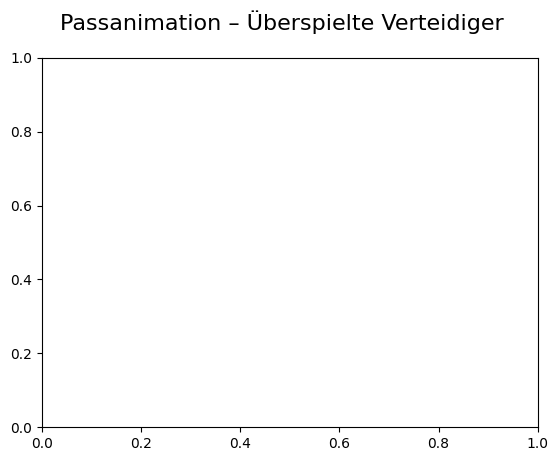

In [347]:
pass_num = 732
frames = list(range(passes_summary[passes_summary['motion_number'] == pass_num]['FRAME_START'].iloc[0], passes_summary[passes_summary['motion_number'] == pass_num]['FRAME_END'].iloc[0]))  # oder eine andere Frame-Range


from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.suptitle("Passanimation – Überspielte Verteidiger", fontsize=16)


# Beispielanimation
def update(frame):
    ax.clear()
    plot_spieler(tracking_data, frame, pass_number=pass_num, ax = ax, plot_pass_area=True)
    return ax,

ani = FuncAnimation(fig, update, frames=frames, interval=400)

plt.show()

In [348]:
ani.save("pass_animation.gif", writer='pillow')

In [349]:
def überspielte_verteidiger(start_frame, end_frame, possession_group, period, passgeber):

    start_data = tracking_data[tracking_data['FRAME'] == start_frame]
    end_data = tracking_data[tracking_data['FRAME'] == end_frame]
    
    ball_start = start_data[start_data['TRACK_ID'] == 55][['X', 'Y']].iloc[0]
    ball_end = end_data[end_data['TRACK_ID'] == 55][['X', 'Y']].iloc[0]

    
    if passgeber in home_team_ids:
        gegner_ids = away_team_ids
    elif passgeber in away_team_ids :
        gegner_ids = home_team_ids

    gegner_start = start_data[start_data['TRACK_ID'].isin(gegner_ids)][['TRACK_ID', 'X', 'Y']].copy()
    gegner_end = end_data[end_data['TRACK_ID'].isin(gegner_ids)][['TRACK_ID', 'X', 'Y']].copy()


    def zwischen_ball_und_tor(row, team, ball_pos):
        if (team == 'away team' and period == 1) or (team == 'home team' and period == 2):
            return row['X'] > ball_pos['X']  # Richtung rechtes Tor
        else:
            return row['X'] < ball_pos['X']  # Richtung linkes Tor

    gegner_start['zwischen'] = gegner_start.apply(lambda row: zwischen_ball_und_tor(row, possession_group, ball_start), axis=1)
    gegner_end['zwischen'] = gegner_end.apply(lambda row: zwischen_ball_und_tor(row, possession_group, ball_end), axis=1)
    
    y_min = min(ball_start['Y'], ball_end['Y']) - 4
    y_max = max(ball_start['Y'], ball_end['Y']) + 4

    # IDs der Gegner, die am Ende im Y-Korridor sind
    gegner_end_ids_in_y_corridor = gegner_end[(gegner_end['Y'] >= y_min) & (gegner_end['Y'] <= y_max)]['TRACK_ID']

    # Filter auf gegner_start anwenden
    überspielt = gegner_start[
        (gegner_start['zwischen']) &
        (~gegner_start['TRACK_ID'].isin(gegner_end[gegner_end['zwischen']]['TRACK_ID'])) &
        (gegner_start['Y'] >= y_min) & (gegner_start['Y'] <= y_max) &
        (gegner_start['TRACK_ID'].isin(gegner_end_ids_in_y_corridor))
    ]

    return len(überspielt)


In [350]:
passes_summary['überspielte Verteidiger'] = passes_summary.apply(
    lambda row: überspielte_verteidiger(row['FRAME_START'], row['FRAME_END'], row['POSSESSION_GROUP_start'], row['PERIOD'], row['Passgeber']),
    axis=1
)

## Pass score - Raumgewinn mit Pass

Betrachte Raumgewinn in x-Richtung mulitpliziert mit Score je nach Spielfeldzone in der ein Pass gespielt wird. Anschließend ermittelt man pro Spieler den Average score pro Pass. Ein niedriger Wert deutet auf viele Quer- und Rückpässe hin.

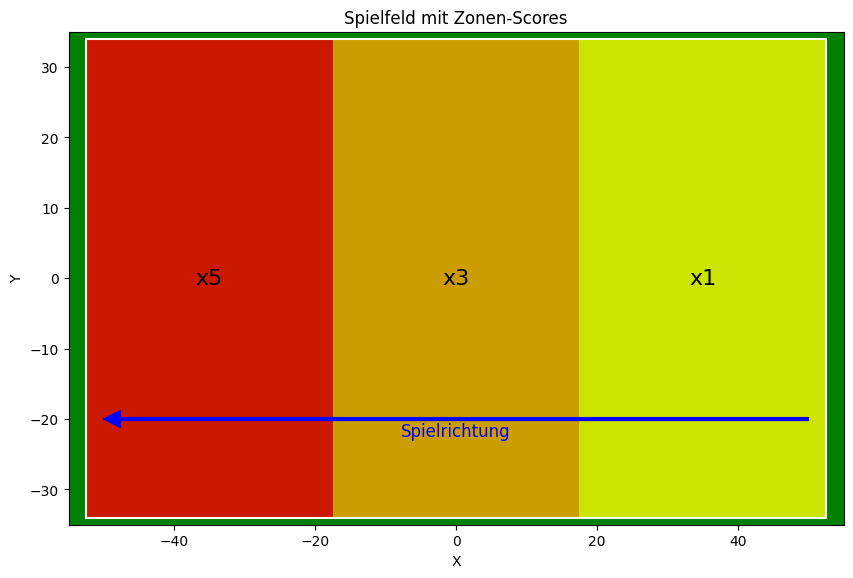

In [351]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(10, 7))
plt.title("Spielfeld mit Zonen-Scores")

# Spielfeld
plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")
plt.gca().set_facecolor("green")
plt.xlim(-55, 55)
plt.ylim(-35, 35)
ax = plt.gca()

# Zonenbereiche (von rechts nach links = Spielrichtung → links = Angriff)
drittel_grenzen = [-52.5, -17.5, 17.5, 52.5]

# Zone 1: Angriff – rot (Score x3)
ax.add_patch(patches.Rectangle(
    (drittel_grenzen[0], -34), 35, 68, facecolor='red', alpha=0.8, label='Score x5'
))
ax.text(-35, 0, "x5", fontsize=16, color='black', ha='center', va='center')

# Zone 2: Mittelfeld – orange (Score x2)
ax.add_patch(patches.Rectangle(
    (drittel_grenzen[1], -34), 35, 68, facecolor='orange', alpha=0.8, label='Score x3'
))
ax.text(0, 0, "x3", fontsize=16, color='black', ha='center', va='center')

# Zone 3: Abwehr – gelb (Score x1)
ax.add_patch(patches.Rectangle(
    (drittel_grenzen[2], -34), 35, 68, facecolor='yellow', alpha=0.8, label='Score x1'
))
ax.text(35, 0, "x1", fontsize=16, color='black', ha='center', va='center')

# Blauer Pfeil für Spielrichtung (rechts → links)
arrow_props = dict(facecolor='blue', edgecolor='blue', width=2)
ax.annotate('', xy=(-50, -20), xytext=(50, -20), arrowprops=arrow_props)
ax.text(0, -22.5, "Spielrichtung", fontsize=12, color='blue', ha='center')

# Linien etc.
ax.set_aspect('equal')
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()


In [352]:
def pass_score(row):
    start_x = row['start_X']
    end_x = row['end_X']
    team_start = row['POSSESSION_GROUP_start']
    team_end = row['POSSESSION_GROUP_end']
    period = row['PERIOD']
    
    # Pass kommt nicht an
    if team_start != team_end:
        return 0

    # Spielrichtung je nach Team & Halbzeit
    if (team_start == 'away team' and period == 1) or (team_start == 'home team' and period == 2):
        # Links → Rechts 
        meter_gain = end_x - start_x
    else:
        # Rechts → Links 
        meter_gain = start_x - end_x

    # Kein Raumgewinn
    if meter_gain <= 0:
        return 0

    # Score-Zonen nach Endposition
    if (team_start == 'away team' and period == 1) or (team_start == 'home team' and period == 2):  #links nach rechts
        if end_x <= -17.5:
            multiplier = 1
        elif end_x <= 17.5:
            multiplier = 3
        else:
            multiplier = 5
    else:                                                                                           # rechts nach links
        if end_x >= 17.5:
            multiplier = 1
        elif end_x >= -17.5:
            multiplier = 3
        else:
            multiplier = 5

    return meter_gain * multiplier

In [353]:
passes_summary['Score'] = passes_summary.apply(pass_score, axis=1)

Normalize scores to values between 0 and 10

In [354]:
# Nur positive Scores berücksichtigen
passes_summary['Score'] = np.log(passes_summary['Score'] + 1)  # Log-Transformation, um Verzerrung durch hohe Werte zu reduzieren
valid_scores = passes_summary['Score'][passes_summary['Score'] > 0]

min_score = valid_scores.min()
max_score = valid_scores.max()

def normalize_score(score):
    if score <= 0:
        return 0
    return 10 * score  / (max_score)

passes_summary['Score'] = passes_summary['Score'].apply(normalize_score)

Text(0.5, 1.0, 'Normalized Pass Scores')

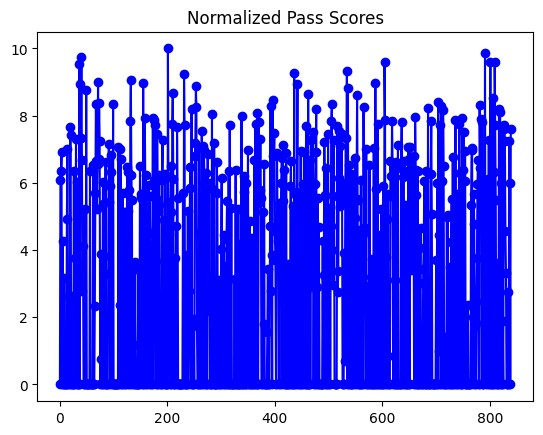

In [355]:
plt.plot(passes_summary['Score'], marker='o', linestyle='-', color='blue')
plt.title("Normalized Pass Scores")

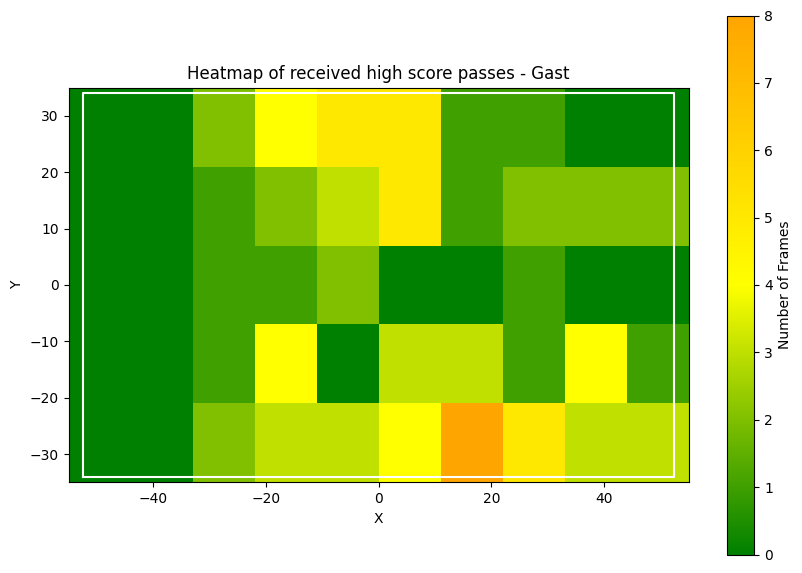

In [356]:
from matplotlib.colors import LinearSegmentedColormap

deep_passes = passes_summary[(passes_summary['Score'] > 4) & (passes_summary['PERIOD'] == 1) & (passes_summary['POSSESSION_GROUP_start'] == 'away team')]

green_red_cmap = LinearSegmentedColormap.from_list("green_red", ["green", "yellow", "orange"])

plt.figure(figsize=(10, 7))
plt.title("Heatmap of received high score passes - Gast")

plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")
plt.xlim(-55, 55)
plt.ylim(-35, 35)
plt.gca().set_facecolor("green")

plt.hist2d(
    deep_passes['end_X'],
    deep_passes['end_Y'],
    bins=[10, 5],           # Anzahl der Bins in X und Y (quadratisch = gleiche Zahl)
    range=[[-55, 55], [-35, 35]],  # Spielfeldgrenzen
    cmap=green_red_cmap
)
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal')
plt.colorbar(label='Number of Frames')
plt.show()

## Player Summary

In [357]:
player_summary = pd.DataFrame()
player_summary['Player'] = tracking_data[tracking_data['TRACK_ID'] != 55]['TRACK_ID'].unique()

In [358]:
player_summary['team'] = player_summary['Player'].apply(lambda x : 'home team' if x in home_team_ids else 'away team')

In [359]:
passes_summary['überspielte Verteidiger'].unique()

array([0, 1, 2, 4, 7, 6, 3, 8, 5], dtype=int64)

In [360]:
player_summary['Pässe'] = player_summary['Player'].apply(lambda x: len(passes_summary[passes_summary['Passgeber'] == x]))
player_summary['Angekommene Pässe'] = player_summary['Player'].apply(lambda x: len(passes_summary[(passes_summary['Passgeber'] == x) & (passes_summary['Angekommen'])]))
player_summary['Fehlpässe'] = player_summary['Player'].apply(lambda x: len(passes_summary[(passes_summary['Passgeber'] == x) & (~passes_summary['Angekommen'])]))
player_summary['Passquote'] = player_summary['Angekommene Pässe'] / player_summary['Pässe']

player_summary['Überspielte Verteidiger'] = player_summary['Player'].apply(lambda x: sum(passes_summary[(passes_summary['Passgeber'] == x) & (passes_summary['Angekommen'])]['überspielte Verteidiger']))
player_summary['Average Pass Score'] = player_summary['Player'].apply(lambda x: passes_summary[passes_summary['Passgeber'] == x]['Score'].sum() / max(1, len(passes_summary[passes_summary['Passgeber'] == x])))

Ermittle wer in der Startaufstellung war.

In [361]:
start_ids = tracking_data[tracking_data['FRAME'] == 60]['TRACK_ID'].unique()
player_summary['Startaufstellung'] = player_summary['Player'].isin(start_ids)

In [362]:
player_summary

,Player,team,Pässe,Angekommene Pässe,Fehlpässe,Passquote,Überspielte Verteidiger,Average Pass Score,Startaufstellung
0,28437,home team,30,24,6,0.800000,1,1.558548,True
1,16471,home team,34,27,7,0.794118,14,3.158630,True
2,28435,away team,19,16,3,0.842105,6,2.325255,True
3,28566,away team,51,41,10,0.803922,23,2.933498,True
4,29957,away team,34,28,6,0.823529,4,2.078690,True
5,29926,away team,38,32,6,0.842105,10,1.846291,True
6,61575,away team,33,31,2,0.939394,13,2.255370,True
7,28555,away team,64,55,9,0.859375,35,3.349324,True
8,39023,away team,57,52,5,0.912281,31,2.733226,True
9,28565,away team,36,31,5,0.861111,3,2.054287,True


Ermittle wann ein Spieler eingewechselt wurde. Finde also das erste Frame an dem es Daten zu dem Spieler gibt und an dem er VISIBLE ist.

In [363]:
def find_einwechslung(player_id):

    in_startelf = player_summary.loc[player_summary['Player'] == player_id, 'Startaufstellung'].iloc[0]

    if in_startelf:
        return "00:00:00"
    
    # Spieler war nicht in der Startaufstellung → finde erstes sichtbares Frame
    visible_rows = tracking_data_full[tracking_data['TRACK_ID'] == player_id]
    if visible_rows.empty:
        return None
    
    first_visible_row = visible_rows.sort_values('TIME_DELTA').iloc[0]
    return first_visible_row['TIMESTAMP']

def find_auswechslung(player_id):

    visible_rows = tracking_data_full[tracking_data['TRACK_ID'] == player_id]
    
    last_visible_row = visible_rows.sort_values('TIME_DELTA').iloc[-1]
    return last_visible_row['TIMESTAMP']

player_summary['Einwechslung'] = player_summary['Player'].apply(find_einwechslung)
player_summary['Auswechslung'] = player_summary['Player'].apply(find_auswechslung)

Ergänze Positionen der Spieler

In [364]:
positions_away = pd.read_pickle("positions_away.pkl")
positions_home = pd.read_pickle("positions_home.pkl")

In [365]:
player_summary['Position'] = player_summary['Player'].apply(lambda x: positions_away[positions_away['TRACK_ID'] == x]['role_x'].iloc[0] if x in positions_away['TRACK_ID'].values else positions_home[positions_home['TRACK_ID'] == x]['role_x'].iloc[0])
player_summary['Seite'] = player_summary['Player'].apply(lambda x: positions_away[positions_away['TRACK_ID'] == x]['role_y'].iloc[0] if x in positions_away['TRACK_ID'].values else positions_home[positions_home['TRACK_ID'] == x]['role_y'].iloc[0])

In [366]:
player_summary

,Player,team,Pässe,Angekommene Pässe,Fehlpässe,Passquote,Überspielte Verteidiger,Average Pass Score,Startaufstellung,Einwechslung,Auswechslung,Position,Seite
0,28437,home team,30,24,6,0.800000,1,1.558548,True,00:00:00,01:10:26.9,Angriff,links
1,16471,home team,34,27,7,0.794118,14,3.158630,True,00:00:00,01:24:39.6,Angriff,zentral
2,28435,away team,19,16,3,0.842105,6,2.325255,True,00:00:00,01:34:36.2,Angriff,zentral
3,28566,away team,51,41,10,0.803922,23,2.933498,True,00:00:00,01:34:36.2,Mittelfeld,links
4,29957,away team,34,28,6,0.823529,4,2.078690,True,00:00:00,01:34:36.2,Angriff,rechts
5,29926,away team,38,32,6,0.842105,10,1.846291,True,00:00:00,01:08:32.9,Mittelfeld,rechts
6,61575,away team,33,31,2,0.939394,13,2.255370,True,00:00:00,00:54:30.1,Mittelfeld,links
7,28555,away team,64,55,9,0.859375,35,3.349324,True,00:00:00,01:08:32.9,Abwehr,zentral
8,39023,away team,57,52,5,0.912281,31,2.733226,True,00:00:00,01:34:36.2,Abwehr,links
9,28565,away team,36,31,5,0.861111,3,2.054287,True,00:00:00,01:34:36.2,Mittelfeld,rechts


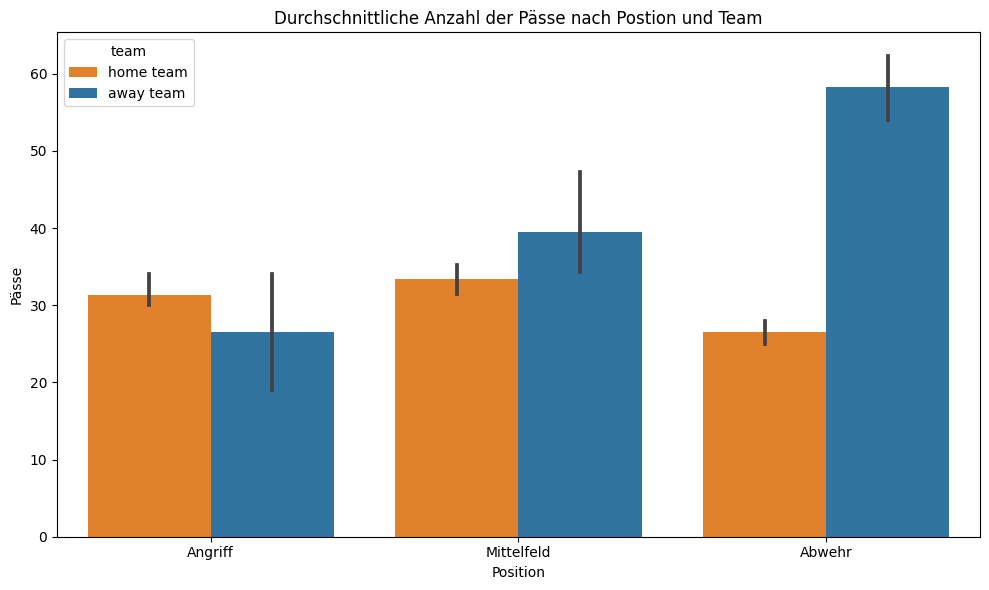

In [378]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=player_summary[(player_summary['Position'] != 'Torwart') & player_summary['Startaufstellung']], x='Position', y='Pässe', hue='team', palette=["#ff7f0e", "#1f77b4"] )
plt.title("Durchschnittliche Anzahl der Pässe nach Postion und Team")
plt.tight_layout()
plt.show()


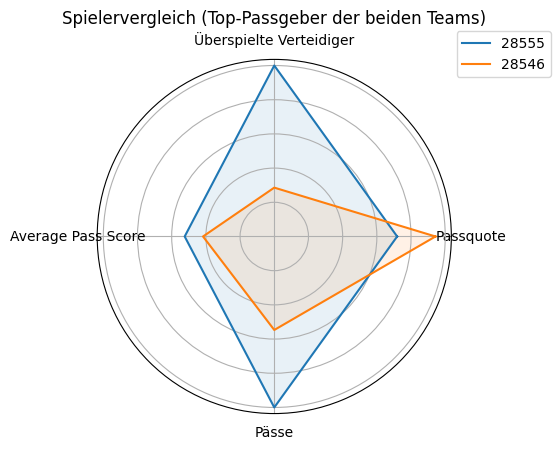

In [375]:
from math import pi
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
import pandas as pd

def radar_chart(df, player_ids):
    stats = ['Passquote', 'Überspielte Verteidiger', 'Average Pass Score', 'Pässe']
    
    df_norm = df.copy()
    for stat in stats:
        min_val = df[stat].min()
        max_val = df[stat].max()
        df_norm[stat] = (df[stat] - min_val) / (max_val - min_val)

    angles = [n / float(len(stats)) * 2 * pi for n in range(len(stats))]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for pid in player_ids:
        row = df_norm[df['Player'] == pid]
        values = row[stats].values.flatten().tolist()
        values += values[:1]
        label = df[df['Player'] == pid]['Player'].values[0]
        ax.plot(angles, values, label=f"{label}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(stats)
    ax.set_title("Spielervergleich (Top-Passgeber der beiden Teams)")
    ax.set_yticklabels([])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

radar_chart(player_summary, [28555,28546])


## Torschüsse erkennen
Falls der Ball in der Torzone gelandet ist.

In [369]:
passes_summary

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger,überspielte Verteidiger,Score
0,1,-0.59,1.84,-13.07,10.93,1.0,away team,away team,95,112,28566,True,28566.0,24372.0,0,0.000000
1,2,-13.24,13.54,-3.90,28.36,1.0,away team,away team,117,131,24372,True,24372.0,39023.0,1,6.087529
2,3,1.99,31.32,-8.89,29.12,1.0,home team,home team,171,188,<NA>,True,16427.0,16471.0,0,6.354547
3,4,-6.60,24.64,8.48,26.09,1.0,away team,away team,233,241,<NA>,True,24372.0,28566.0,1,6.929556
4,5,8.95,31.28,18.22,23.76,1.0,away team,home team,259,268,<NA>,False,39023.0,39015.0,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True,39023.0,39023.0,0,0.000000
836,837,6.68,-20.79,-11.24,-32.42,2.0,away team,away team,57136,57162,<NA>,True,39023.0,39023.0,0,7.235226
837,838,-26.85,-21.97,-32.17,-1.23,2.0,away team,away team,57325,57349,<NA>,True,14926.0,29957.0,1,5.996849
838,839,-32.55,0.98,-21.53,-21.72,2.0,away team,away team,57355,57364,<NA>,True,29957.0,39023.0,0,0.000000


In [370]:
passes_summary['Torschuss'] = ((passes_summary['end_X'] > 50) | (passes_summary['end_X'] < -50)) & (passes_summary['end_Y'].abs() < 10)

In [371]:
passes_summary[passes_summary['Torschuss']]

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger,überspielte Verteidiger,Score,Torschuss
72,73,51.83,-23.58,59.84,-0.59,1.0,away team,away team,4950,4968,28565,True,28565.0,28566.0,0,6.714369,True
105,106,-44.01,12.08,-50.62,4.05,1.0,away team,away team,6965,6974,<NA>,True,39023.0,16663.0,0,0.000000,True
279,280,-31.66,12.72,-50.07,-9.69,1.0,home team,away team,17422,17438,<NA>,False,28437.0,28565.0,7,0.000000,True
295,296,37.47,-4.04,53.68,8.06,1.0,home team,home team,18945,18959,<NA>,True,28540.0,29938.0,0,0.000000,True
458,459,-37.92,-16.85,-51.84,-7.19,2.0,away team,away team,28935,28950,<NA>,True,39023.0,61575.0,5,7.694450,True
716,717,-54.68,13.69,-57.33,9.82,2.0,home team,home team,48920,48927,<NA>,True,28546.0,28546.0,0,0.000000,True
829,830,-49.37,-23.31,-51.68,-3.60,2.0,away team,away team,56700,56718,<NA>,True,28566.0,28566.0,1,4.572391,True


[21200, 21201, 21202, 21203, 21204, 21205, 21206, 21207, 21208, 21209, 21210, 21211, 21212, 21213, 21214, 21215, 21216, 21217, 21218, 21219, 21220, 21221, 21222, 21223, 21224, 21225, 21226, 21227, 21228, 21229, 21230, 21231, 21232, 21233, 21234, 21235, 21236, 21237, 21238, 21239, 21240, 21241, 21242, 21243, 21244, 21245, 21246, 21247, 21248, 21249, 21250, 21251, 21252, 21253, 21254, 21255, 21256, 21257, 21258, 21259, 21260, 21261, 21262, 21263, 21264, 21265, 21266, 21267, 21268, 21269, 21270, 21271, 21272, 21273, 21274, 21275, 21276, 21277, 21278, 21279, 21280, 21281, 21282, 21283, 21284, 21285, 21286, 21287, 21288, 21289, 21290, 21291, 21292, 21293, 21294, 21295, 21296, 21297, 21298, 21299, 21300, 21301, 21302, 21303, 21304, 21305, 21306, 21307, 21308, 21309, 21310, 21311, 21312, 21313, 21314, 21315, 21316, 21317, 21318, 21319, 21320, 21321, 21322, 21323, 21324, 21325, 21326, 21327, 21328, 21329, 21330, 21331, 21332, 21333, 21334, 21335, 21336, 21337, 21338, 21339, 21340, 21341, 21342

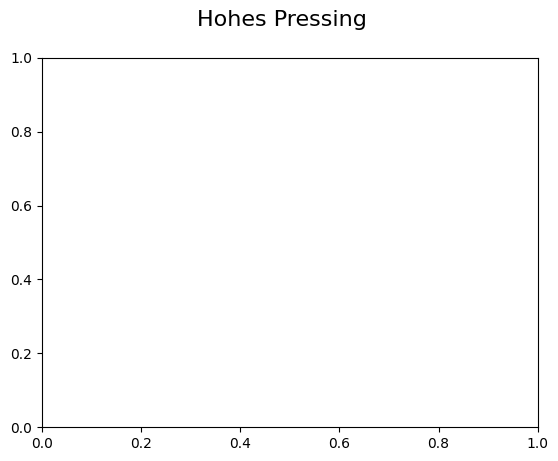

In [372]:
import matplotlib.patches as patches

def plot_ballbesitz_phase(frame_start, frame_end):
    def plot_spieler(tracking_df, frame, team0_ids=away_team_ids, team1_ids=home_team_ids, ball_id=55, ax=None):
        df = tracking_df[tracking_df['FRAME'] == frame]

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 7))
        
        ax.set_facecolor('green')
        ax.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")

        ax.set_xlim(-55, 55)
        ax.set_ylim(-35, 35)
        ax.set_aspect('equal')


        for _, row in df.iterrows():
            if row['TRACK_ID'] == ball_id:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10, label='Ball')
            elif team0_ids and row['TRACK_ID'] in team0_ids:
                ax.plot(row['X'], row['Y'], 'o', color='blue', label='Auswärts')
            elif team1_ids and row['TRACK_ID'] in team1_ids:
                ax.plot(row['X'], row['Y'], 'o', color='red', label='Heim')
            else:
                ax.plot(row['X'], row['Y'], 'o', color='gray')

        ball_pos = df[df['TRACK_ID'] == 55]
        ball_x = ball_pos['X'].iloc[0]
        ball_y = ball_pos['Y'].iloc[0]
        gegner_ids = home_team_ids if df['POSSESSION_GROUP'].iloc[0] == 'away team' else away_team_ids


    
    tracking_frames = set(tracking_data['FRAME'].unique())
    frames = [f for f in range(frame_start, frame_end+1) if f in tracking_frames]

    if len(frames) == 0:
        print("Keine gültigen Frames für diese Ballbesitzphase.")
        return



    from matplotlib.animation import FuncAnimation
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    fig.suptitle("Hohes Pressing", fontsize=16)


    # Beispielanimation
    def update(frame):
        ax.clear()
        plot_spieler(tracking_data_full, frame, ax = ax)
        return ax,

    ani = FuncAnimation(fig, update, frames=frames, interval=200)
    print(frames)

    plt.show()
    ani.save("spielszene.gif", writer='pillow')

#plot_ballbesitz_phase(4900, 5200)  #--> Abstoß
#plot_ballbesitz_phase(6900, 7500)  # Abstoß
#plot_ballbesitz_phase(17300, 17800)  # undefinierbar
#plot_ballbesitz_phase(18850, 19600) # evtl Tor, aber für away team
#plot_ballbesitz_phase(28900, 29500) # schöner Torschuss, aber Abstoß
#plot_ballbesitz_phase(48800, 49300) # Ecke
#plot_ballbesitz_phase(56600, 57400) # undefinierbar
plot_ballbesitz_phase(21200, 22500)


Torschuss mit motion_number 296 wurde als Tor identifiziert für "away team". Danach folgt eine Spielunterbrechung und der Ball startet von der Mitte aus wieder. Bei allen anderen Torschüssen, geht das Spiel mit einer Ecke oder einem Abstoß weiter.

Endstand 1:0 für away_team!

In [373]:
passes_summary.to_pickle('passes.pkl')
player_summary.to_pickle('player_summary.pkl')

In [374]:
passes_summary[passes_summary['Passempfänger'] == passes_summary['Passgeber']]

,motion_number,start_X,start_Y,end_X,end_Y,PERIOD,POSSESSION_GROUP_start,POSSESSION_GROUP_end,FRAME_START,FRAME_END,POSSESSION_TRACKABLE_OBJECT,Angekommen,Passgeber,Passempfänger,überspielte Verteidiger,Score,Torschuss
5,6,14.35,15.84,11.16,10.30,1.0,home team,home team,309,317,<NA>,True,28546.0,28546.0,0,4.262047,False
8,9,-3.50,2.14,-1.90,6.31,1.0,away team,away team,389,396,<NA>,True,14926.0,14926.0,1,3.177274,False
10,11,11.71,25.14,22.13,30.85,1.0,home team,home team,426,440,<NA>,True,28547.0,28547.0,0,0.000000,False
16,17,-20.12,30.75,-28.88,31.32,1.0,away team,away team,954,968,39023,True,39023.0,39023.0,0,0.000000,False
37,38,16.19,1.55,7.68,7.09,1.0,away team,away team,2679,2687,<NA>,True,28566.0,28566.0,0,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,824,20.05,17.31,19.86,28.20,2.0,home team,home team,56289,56307,<NA>,True,28546.0,28546.0,0,0.000000,False
828,829,-40.82,-7.18,-51.71,-32.07,2.0,away team,away team,56619,56645,<NA>,True,28566.0,28566.0,1,7.257858,False
829,830,-49.37,-23.31,-51.68,-3.60,2.0,away team,away team,56700,56718,<NA>,True,28566.0,28566.0,1,4.572391,True
835,836,-0.53,-19.75,3.27,-20.59,2.0,away team,away team,57105,57112,<NA>,True,39023.0,39023.0,0,0.000000,False
